### Import Libraries

In [52]:
import pandas as pd                  # Pandas
import numpy as np                   # Numpy
from matplotlib import pyplot as plt # Matplotlib

# Package to implement ML Algorithms
import sklearn
from sklearn.metrics import r2_score, mean_squared_error

# Package to implement XGboost
import xgboost as xgb
from xgboost import XGBRegressor

# Import MAPIE to calculate prediction intervals
from mapie.regression import MapieRegressor

# To calculate coverage score
from mapie.metrics import regression_coverage_score

# Package for data partitioning
from sklearn.model_selection import train_test_split, GridSearchCV

# Package to record time
import time

# Module to save and load Python objects to and from files
import pickle 

# Ignore Deprecation Warnings
import warnings
warnings.filterwarnings('ignore')

# Display inline plots as vector-based (svg)
%config InlineBackend.figure_formats = ['svg']

%matplotlib inline

### Load Dataset

In [24]:
# Import Data
df = pd.read_csv('Traffic_Volume.csv')
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,10/2/12 9:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,10/2/12 10:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,10/2/12 11:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,10/2/12 12:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,10/2/12 13:00,4918


In [25]:
# Change date_time format
df['date_time'] = pd.to_datetime(df['date_time'])

# Add month and year columns
df['month'] = df['date_time'].dt.month_name()
df['year'] = df['date_time'].dt.year
df['weekday'] = df['date_time'].dt.day_name()
df['hour'] = df['date_time'].dt.hour

# Ensure year, month, day of the week, and hour within specified ranges
df['year'] = df['year'].clip(lower=2012, upper=2018).astype(int)
df['weekday'] = df['weekday'].apply(lambda x: x.capitalize())  # Capitalize day names
df['hour'] = df['hour'].clip(lower=0, upper=23).astype(int)
df['hour'] = df['hour'].astype('object')
df['year'] = df['year'].astype('object')


df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,date_time,traffic_volume,month,year,weekday,hour
0,NaN,288.28,0.0,0.0,40,Clouds,2012-10-02 09:00:00,5545,October,2012,Tuesday,9
1,NaN,289.36,0.0,0.0,75,Clouds,2012-10-02 10:00:00,4516,October,2012,Tuesday,10
2,NaN,289.58,0.0,0.0,90,Clouds,2012-10-02 11:00:00,4767,October,2012,Tuesday,11
3,NaN,290.13,0.0,0.0,90,Clouds,2012-10-02 12:00:00,5026,October,2012,Tuesday,12
4,NaN,291.14,0.0,0.0,75,Clouds,2012-10-02 13:00:00,4918,October,2012,Tuesday,13


In [26]:
df['holiday'] = np.where(pd.isna(df['holiday']), "None", df['holiday'])
df = df.drop(['date_time'], axis=1)
df = df.drop(['year'], axis=1)
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,traffic_volume,month,weekday,hour
0,None,288.28,0.0,0.0,40,Clouds,5545,October,Tuesday,9
1,None,289.36,0.0,0.0,75,Clouds,4516,October,Tuesday,10
2,None,289.58,0.0,0.0,90,Clouds,4767,October,Tuesday,11
3,None,290.13,0.0,0.0,90,Clouds,5026,October,Tuesday,12
4,None,291.14,0.0,0.0,75,Clouds,4918,October,Tuesday,13


In [27]:
print(df.dtypes)

holiday            object
temp              float64
rain_1h           float64
snow_1h           float64
clouds_all          int64
weather_main       object
traffic_volume      int64
month              object
weekday            object
hour               object
dtype: object


In [28]:
# Select input and output features
X = df.drop(columns = ['traffic_volume'])
y = df['traffic_volume']


In [29]:
# One hot encoding for categorical variables
X_encoded = pd.get_dummies(X)
X_encoded.head()

,temp,rain_1h,snow_1h,clouds_all,holiday_Christmas Day,holiday_Columbus Day,holiday_Independence Day,holiday_Labor Day,holiday_Martin Luther King Jr Day,holiday_Memorial Day,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,288.28,0.0,0.0,40,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,289.36,0.0,0.0,75,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,289.58,0.0,0.0,90,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,290.13,0.0,0.0,90,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,291.14,0.0,0.0,75,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### Implement XGBoost Regressor

In [30]:
# Data partitioning into train and test sets
train_X, test_X, train_y, test_y = train_test_split(X_encoded, y, test_size = 0.2, random_state = 42)

In [31]:
# Define parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [190, 210, 230],
    'max_depth': [8, 10, 12],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Initialize GridSearchCV with XGBRegressor and perform tuning
grid_search = GridSearchCV(
    estimator=XGBRegressor(objective='reg:squarederror'),
    param_grid=param_grid,
    cv=3,                 # 3-fold cross-validation
    scoring='r2',         # Use R-squared as the evaluation metric
    verbose=1,
    n_jobs=-1             # Use all available processors
)

# Start time for training
start = time.time()
grid_search.fit(train_X, train_y)  
stop = time.time()

# Display the best parameters and the training time
print(f"Training time: {stop - start}s")
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation R-squared: ", grid_search.best_score_)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Training time: 132.62788772583008s
Best parameters found:  {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 12, 'n_estimators': 190, 'subsample': 1.0}
Best cross-validation R-squared:  0.9490860104560852


#### Evaluate Prediction Performance on Test Set

In [56]:
# Train a final model with the best parameters on the entire training set
grid_search = grid_search.best_estimator_

# Predict on the test set
y_pred = grid_search.predict(test_X)

# Evaluate the model on the test set
r2 = r2_score(test_y, y_pred)
rmse = mean_squared_error(test_y, y_pred, squared=False)
print('R-squared on Test Set: %0.2f' % r2)
print('RMSE on Test Set: %0.2f' % rmse)

R-squared on Test Set: 0.95
RMSE on Test Set: 431.53


#### Histogram of Residuals/Errors 

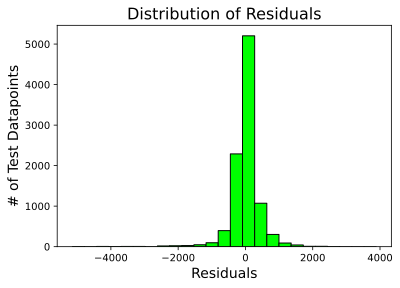

In [54]:
# Calculate the residuals by subtracting the predicted values from the actual test values
all_residuals = test_y - y_pred

# Set up the figure with custom size and resolution (DPI)
plt.figure(figsize=(6, 4), dpi = 150)

# Plot the histogram of residuals
plt.hist(all_residuals, bins = 25, color = 'lime', edgecolor = 'black')

# Label X and Y axes
plt.xlabel('Residuals', fontsize = 14)
plt.ylabel('# of Test Datapoints', fontsize = 14)

# Set the title of the plot
plt.title('Distribution of Residuals', fontsize = 16)

# Adjust the font size of x and y ticks
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);

#### Scatter Plot of Predicted Vs. Actual Values

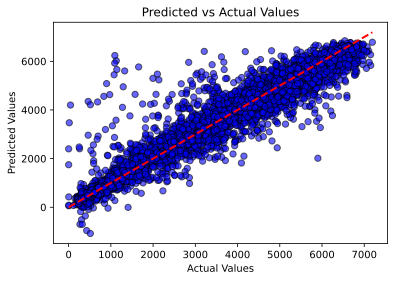

In [55]:
# Setting the figure size and resolution
plt.figure(figsize = (6, 4), dpi = 150)

# Scatter plot of actual vs predicted values
plt.scatter(test_y, y_pred, color = 'blue', alpha = 0.6, edgecolor = 'black', s = 40)

# 45-degree reference line (perfect predictions)
plt.plot([min(test_y), max(test_y)], [min(test_y), max(test_y)], color = 'red', linestyle = '--', lw = 2)

# Axis labels and title
plt.xlabel('Actual Values', fontsize = 10)
plt.ylabel('Predicted Values', fontsize = 10)
plt.title('Predicted vs Actual Values', fontsize = 12)

# Adjust ticks
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);

#line represents perfect prediction

#### Feature Importance Plot

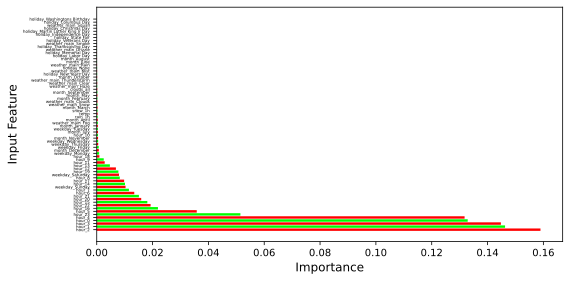

In [57]:
# Storing importance values from the trained model
importance = grid_search.feature_importances_

# Storing feature importance as a dataframe
feature_imp = pd.DataFrame(list(zip(train_X.columns, importance)),
               columns = ['Feature', 'Importance'])

feature_imp = feature_imp.sort_values('Importance', ascending = False).reset_index(drop = True)

# Bar plot
plt.figure(figsize=(8, 4))
plt.barh(feature_imp['Feature'], feature_imp['Importance'], color = ['red', 'lime'])

plt.xlabel("Importance", fontsize = 12)
plt.ylabel("Input Feature", fontsize = 12)
plt.yticks(fontsize = 4) # fontsize of yticks
plt.xticks(fontsize = 10) # fontsize of xticks

plt.tight_layout();

### Prediction Intervals for Regression
<img src="Prediction_Interval.png" width="500" style="float: center"/>

#### **What is a Prediction Interval?**
- It is a **range of values** within which a new observation is expected to fall with a **certain probability**, given the existing data and model.

- **Probability**: The width of the prediction interval depends on the **desired confidence level**, (e.g., 95%), with higher confidence levels leading to wider intervals.

#### **Confidence Level of Prediction Interval**

- The confidence level of a prediction interval indicates the probability that the interval will contain the true value of the parameter being estimated.

- Mathematically, the confidence level of a prediction interval is denoted by $ (1 - \alpha) \times 100\% $, where $ \alpha $ is the significance level.

#### **Why Prediction Intervals are Useful?**

- **Uncertainty Quantification**: They provide a measure of the uncertainty in individual predictions, which is crucial for risk assessment and decision-making.

- **Communication**: They are an effective tool for communicating the uncertainty in predictions to stakeholders, making the model's predictions more interpretable.

#### **Prediction Intervals using MAPIE Regressor**

***MAPIE: Model Agnostic Prediction Interval Estimator***

- It is a Python library designed to estimate prediction intervals in a **model-agnostic way**.
- It can be used with **any machine learning model**, including linear models, decision trees, ensemble methods, and neural networks.

[**See this link for detailed description on `MAPIE`**](https://mapie.readthedocs.io/en/latest/generated/mapie.regression.MapieRegressor.html)

In [58]:
# Define MAPIE regressor
mapie = MapieRegressor(estimator = grid_search,     # Prediction model to use
                       n_jobs = -1,         # How many CPUs you want to use to run this project/model (-1 is all)
                       random_state = 42)   

# Fit mapie regressor on training data
start = time.time()  
mapie.fit(train_X, train_y)
stop = time.time()             
print(f"Training time: {stop - start}s")

alpha = 0.1 # For 90% confidence level

# Use mapie.predict() to get predicted values and intervals
y_test_pred, y_test_pis = mapie.predict(test_X, alpha = alpha)

Training time: 2.6556451320648193s


In [59]:
# Predicted values
y_test_pred

array([5393.9517, 2178.6492,  710.8656, ..., 2144.0583, 2745.6716,
        623.1075], dtype=float32)

In [60]:
# Prediction Intervals
y_test_pis

array([[[4473.05761719],
        [6066.65539551]],

       [[1632.81860352],
        [2797.08032227]],

       [[ 121.37841797],
        [1281.2668457 ]],

       ...,

       [[1546.95556641],
        [2728.19897461]],

       [[2183.03759766],
        [3342.11230469]],

       [[  60.56408691],
        [1232.63134766]]])

In [61]:
# Storing results in a dataframe
predictions = test_y.to_frame()
predictions.columns = ['Actual Value']
predictions["Predicted Value"] = y_test_pred.round(2)
predictions["Lower Value"] = y_test_pis[:, 0].round(2)
predictions["Upper Value"] = y_test_pis[:, 1].round(2)

# Take a quick look
predictions.tail(5)

,Actual Value,Predicted Value,Lower Value,Upper Value
6401,2491,2708.020020,2123.31,3288.92
34004,5251,5385.669922,4777.55,5939.79
46086,2224,2144.060059,1546.96,2728.20
42579,2928,2745.669922,2183.04,3342.11
23709,910,623.109985,60.56,1232.63


### **Coverage Calculation**
- **Coverage** refers to the proportion of true/actual values that fall within the prediction intervals generated by a model.

- It is a measure of how well the prediction intervals capture the actual values.

  $\text{Coverage} = \frac{\text{Number of actual values within prediction intervals}}{\text{Total number of actual values}}$

In [62]:
coverage = regression_coverage_score(test_y,           # Actual values
                                     y_test_pis[:, 0], # Lower bound of prediction intervals
                                     y_test_pis[:, 1]) # Upper bound of prediction intervals

coverage_percentage = coverage * 100
print(f"Coverage: {coverage_percentage:.2f}%")

Coverage: 91.80%


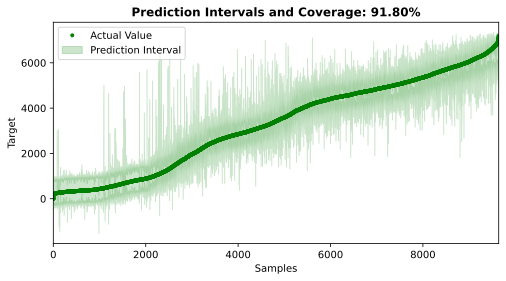

In [63]:
# Sort the predictions by 'Actual Value' for better visualization and reset the index
sorted_predictions = predictions.sort_values(by=['Actual Value']).reset_index(drop=True)

# Create a figure and axis object with specified size and resolution
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the actual values with green dots
plt.plot(sorted_predictions["Actual Value"], 'go', markersize=3, label="Actual Value")

# Fill the area between the lower and upper bounds of the prediction intervals with semi-transparent green color
plt.fill_between(np.arange(len(sorted_predictions)),
                 sorted_predictions["Lower Value"],
                 sorted_predictions["Upper Value"],
                 alpha=0.2, color="green", label="Prediction Interval")

# Set font size for x and y ticks
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Set the limit for the x-axis to cover the range of samples
plt.xlim([0, len(sorted_predictions)])

# Label the x-axis and y-axis with appropriate font size
plt.xlabel("Samples", fontsize=10)
plt.ylabel("Target", fontsize=10)

# Add a title to the plot, including the coverage percentage, with bold formatting
plt.title(f"Prediction Intervals and Coverage: {coverage_percentage:.2f}%", fontsize=12, fontweight="bold")

# Add a legend to the plot, placed in the upper left, with specified font size
plt.legend(loc="upper left", fontsize=10);

### Save Model

In [64]:
# Creating the file where we want to write the model
bst_pickle = open('traffic_volume.pickle', 'wb') 

# Write RF model to the file
pickle.dump(mapie, bst_pickle) 

# Close the file
bst_pickle.close()